# Geometric intuition for the Lennard-Jones potential

The Lennard-Jones potential is conceptually very simple, but performing optimization on it can be difficult. While we "see" the system as $N$ particles interacting with each other, each creating its own potential well, affecting the remaining particles; a computer "sees" the system as just a $3N$-dimensional function whose minimal value it will attempt to find (and the value of its $3N$ parameters).

The function has a couple of features/intricacies. Its value is invariant under all global translations and rotations (since it only depends on inter-particle distances). It has a bunch of singularities (whenever the distance between two particles approaches zero), uncountably many, in fact! This is again due to the translation/rotation invariance of the system. Likewise, there is an uncountably infinite set of global minima.

To figure out how "close" we are to a global minimum, we can therefore not just look at the parameters of our system, both because there are a lot of them, but also because there is no "one" global minimum. The total potential energy of the system is only an indicator of the global minimum, if you already know its value (ie, if you only have your own implementation and solution, how do you know you've actually reached a global minimum?)

So we need some other way of judging the quality of our solution. This is where geometric intuition comes into play.

First we set up the stuff we need: Here some general functions to make us a nice 3D plot with the data we will generate

- James Avery (2022)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Some stuff we will need for 3D plotting
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Make 3D plots interactive in the notebook
# Tested on jupyter-lab >= 4.0 and 
# requires `pip install ipympl`

%matplotlib widget


In [3]:
# Experimental value for sigma (in Ånsgtrom)
SIGMA = 3.401
# Length of minimal potential strength
minlen = 2**(1/6) * SIGMA


# Helper functions for pretty 3d plots easily
def create_3d_plot():
    # We need to pass this dictionary to all subplots we create, so the axes becomes 3D
    plot_dict = dict(projection='3d')
    fig, ax = plt.subplots(subplot_kw=plot_dict)
    return fig, ax


def make_axis_equal(ax):
    # It is incredibly annoying to get an equal aspect ratio in 3d using matplotlib
    # What we need to do is set all the coordinate axis limits equal. This function does just that.
    x1, x2 = ax.get_xlim()
    y1, y2 = ax.get_ylim()
    z1, z2 = ax.get_zlim()
    
    m1 = min(x1, y1, z1)
    m2 = max(x2, y2, z2)
    ax.set_xlim(m1, m2)
    ax.set_ylim(m1, m2)
    ax.set_zlim(m1, m2)
    
    # Also, we need to use orthographic projection instead of perspective projection
    ax.set_proj_type("ortho")
    return ax


def transparent_axis_background(ax):
    # make the panes transparent
    ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
    # make the grid lines transparent
    ax.xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    ax.zaxis._axinfo["grid"]['color'] =  (1,1,1,0)
    # Disable the axes
    ax.axis("off")
    return ax


def plot_min_distances(ax, points, cutoff=1.01*minlen):
    # points: (N,3)-array of (x,y,z) coordinates for N points
    # distance(points): returns (N,N)-array of inter-point distances:
    displacement = points[:, np.newaxis] - points[np.newaxis, :]
    r = np.sqrt(np.sum(displacement*displacement, axis=-1))
    
    # Grab only those that are in upper triangular part
    r = np.triu(r)
    
    # Grab lengths that are above 0, but below the cutoff
    mask = (r <= cutoff) * (r > 0)
    
    # Grab the indices of elements that satisfy the mask above
    ii, jj = np.where(mask)
    
    # For each pair of indices (corresponding to a distance close to optimal)
    # we plot a line between the corresponding points
    for i, j in zip(ii, jj):
        p = points[[i, j]]
        ax.plot(*p.T, color='k', ls="-")
    return ax


def create_base_plot(points):
    # Create the figure and 3D axis
    fig, ax = create_3d_plot()
    
    # translate points so centre of mass is at origin
    m = np.mean(points, axis=0)
    points = np.array(points) - m[np.newaxis, :]
    
    # Plot points and lines between points that are near to optimal
    ax.scatter(*points.T)
    ax = plot_min_distances(ax, points)
    return ax, points


def make_plot_pretty(ax):
    # Make the plot pretty
    ax = transparent_axis_background(ax)
    ax = make_axis_equal(ax)
    return ax


### Helper functions for raw data
The following functions is what we will use to calculate the particle positions we need. Don't worry if you don't understand the computations, you won't need to use them

In [4]:

def equilateral(d=minlen):
    # Creates an equilateral triangle in the plane
    return np.array([[0, 0, 0],
                     [1, 0, 0],
                     [0.5, np.sqrt(3)/2, 0]])*d

def tetrahedron_top(r1, r2, r3, d=minlen):
    # Creates the "top" of the regular tetrahedron, from an equilateral triangle 
    m = (r1+r2+r3)/3
    n = np.cross(r2-r1, r3-r1)
    nhat = n/np.linalg.norm(n, 2)
    
    h = np.sqrt(6)/3
    return m + d*h*nhat

def reflection(r1, r2, r3, r4):
    # Reflects a point r4, across the plane spanned by r1, r2 and r3
    # Used to place new particles 
    m = (r1 + r2 + r3)/3
    n = np.cross(r2-r1, r3-r1)
    nhat = n/np.linalg.norm(n,2)
    v = r4-2*np.dot(r4-m, nhat)*nhat
    return v

r1, r2, r3 = equilateral()

## Let's build a global minimum!
We start with the base case: $N=2$.

For any two particles, the minimum energy is one in which the distance between them is the optimal distance, say $r_0$. Starting with a configuration of two particles at the optimal distance, we can iteratively build up the global solutions by adding a single new particle at a time.

Below we see such a situation. It's rather boring, I'll admit, but it will be an important building block

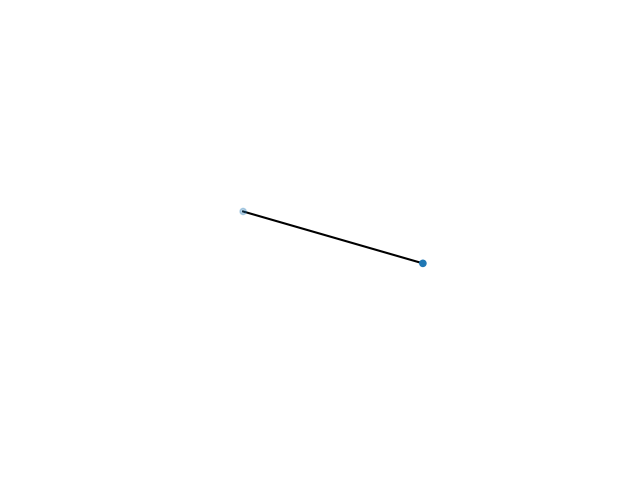

In [5]:
ax = make_plot_pretty(create_base_plot([r1, r2])[0])

To go from $N=2$ to $N=3$, we imagine keeping the positions of the two original particles fixed, allowing only the position of the third particle to change. In this setup, the third particle can achieve a distance of $r_0$ to both of the original particles placing itself such that they form an equilateral triangle. There is a rotational symmetry to this system, and the set of optimal positions for the third particle form a circle about the middle of the separating line between the two original particles.

We can add this circle (and the resulting equilateral triangle) to the plot of the two particle system:

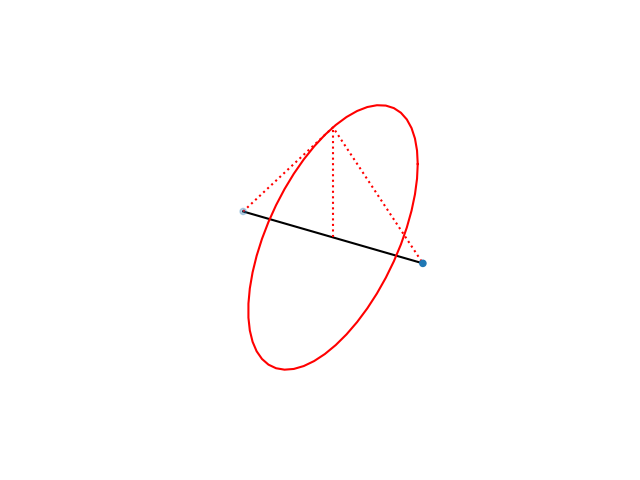

In [6]:
ax = make_plot_pretty(create_base_plot([r1, r2])[0])

# Create the data for a circle of the correct length
N = 50
radius = np.sqrt(6)/3 * minlen
theta = np.linspace(0, 2*np.pi,N)

# Convert angle to cartesian coordinates. Circle in yz-plane, with center at the origin
points = np.zeros([N, 3])
points[:, 0] = 0
points[:, 1] = radius*np.cos(theta)
points[:, 2] = radius*np.sin(theta)

# Plot the cirlce and the triangles
ax.plot(*points.T, color="r")
ax.plot([0, 0], [0, 0], [0, radius], color='r', ls="dotted")
ax.plot([-minlen/2, 0, minlen/2], [0, 0, 0], [0, radius, 0], color="r", ls="dotted")

Next we choose a $\theta$ to place the third particle. In this case I have chosen $\theta=0$, so the equilateral triangle is in the $xy$-plane.

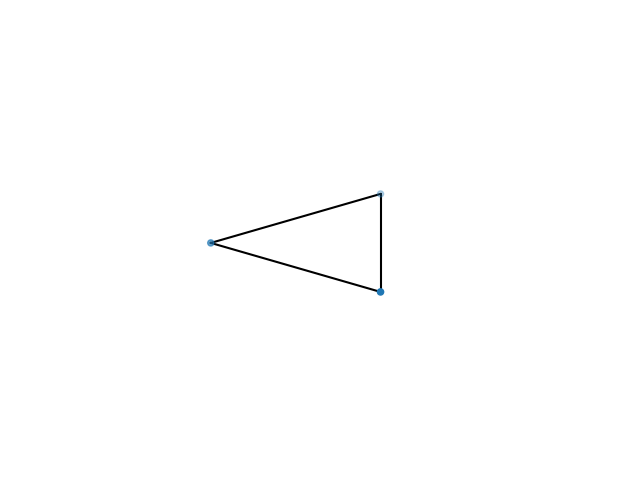

In [7]:
triangle = [r1, r2, r3]
ax, (r1, r2, r3) = create_base_plot(triangle)
ax = make_plot_pretty(ax)

For $N=4$ it is still possible to have all pairs of particles at optimal distances to each other. From the equilateral triangle of $N=3$, we can place the fourth particle in one of two locations to create a regular tetrahedron: "above" and "below" the centre of the equilateral triangle, plotted in red

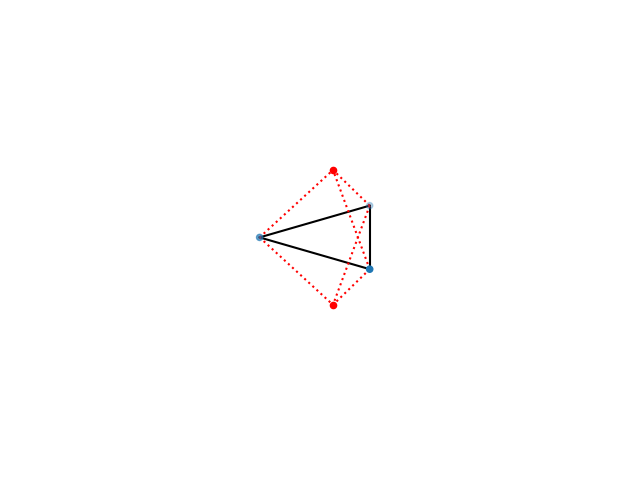

In [8]:
triangle = [r1, r2, r3]
ax, (r1, r2, r3) = create_base_plot(triangle)
r4 = tetrahedron_top(r1, r2, r3)
r5 = tetrahedron_top(r1, r3, r2)
ax.scatter(*r4, color="r")
ax.scatter(*r5, color="r")

points = np.array([r1, r2, r3, r4, r5])
arcs = [[0, 3], [1, 3], [2, 3],
        [0, 4], [1, 4], [2, 4]]
for arc in arcs:
    p = points[arc]
    ax.plot(*p.T, color="r", ls="dotted")

ax = make_plot_pretty(ax)


Again, we choose one. In this case the one above the $xy$-plane. And indeed we get a nice regular tetrahedron

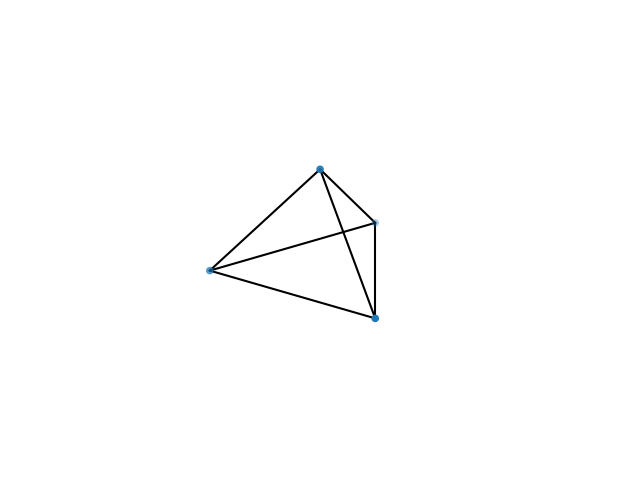

In [9]:
r4 = tetrahedron_top(r1, r2, r3)
tetrahedron = [r1, r2, r3, r4]

ax = make_plot_pretty(create_base_plot(tetrahedron)[0])

After $N=4$ the situation changes, and we will have pairs of particles not at optimal distances. But for each new particle we add, we can ensure that it has at least 3 bonds at the optimal distance $r_0$, by placing the new particle such that it constitutes a regular tetrahedron with three other particles.

For $N=5$ we have 4 ways of placing the fifth particle so it has 3 optimal bonds, one for each face of the regular tetrahedron

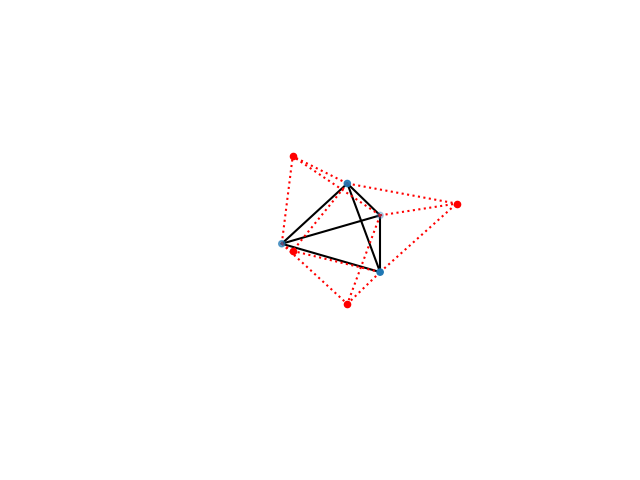

In [10]:
ax, points = create_base_plot(tetrahedron)

indices = [[2, 1, 0, 3],
           [0, 1, 3, 2],
           [1, 2, 3, 0],
           [2, 0, 3, 1]]
for row in indices:
    R = points[row]
    r = reflection(*R)
    ax.scatter(*r, color="r")
    
    for p in R[:-1]:
        ax.plot([p[0], r[0]], [p[1], r[1]], [p[2], r[2]], color="r", ls="dotted")

ax = make_plot_pretty(ax)

And the result of choosing one of those 4 points is seen below, where we now have two regular tetrahedra, sharing a face:

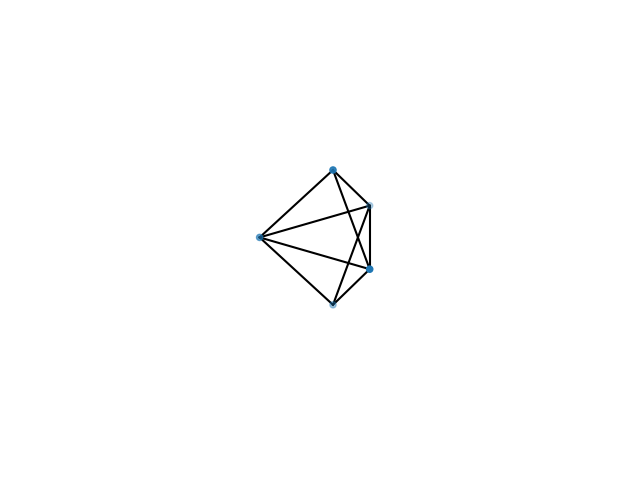

In [11]:
D5 = tetrahedron + [reflection(*[tetrahedron[i] for i in indices[0]])]

ax, points = create_base_plot(D5)
ax = make_plot_pretty(ax)

For $N=6$ we now have 6 ways of positioning the 6th particle with 3 optimal bonds, by forming a regular tetrahedron with any of the outward-facing faces of the two tetrahedra:

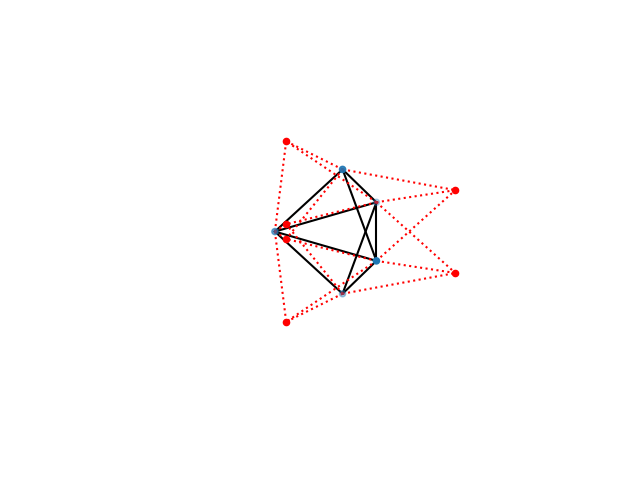

In [12]:
indices = [[3, 2, 0, 1],
           [0, 1, 3, 2],
           [1, 2, 3, 0],
           [2, 1, 4, 0],
           [1, 0, 4, 2],
           [0, 2, 4, 1]]


ax, points = create_base_plot(D5)
for row in indices:
    R = points[row]
    r = reflection(*R)
    ax.scatter(*r, color="r")
    
    for p in R[:-1]:
        ax.plot([p[0], r[0]], [p[1], r[1]], [p[2], r[2]], color="r", ls="dotted")


ax = make_plot_pretty(ax)

And the result is this wonky looking shape, consisting of 3 regular tetrahedra

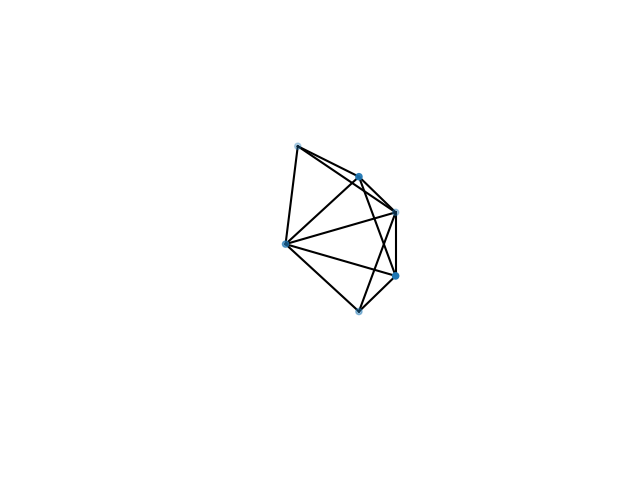

In [13]:
D6 = D5 + [reflection(*[D5[i] for i in indices[0]])]
ax, points = create_base_plot(D6)

last_point = points[-1]
ax = make_plot_pretty(ax)

After $N=6$ things get a bit more hairy: We can either keep "growing" the structure in a given direction, or try to grow it "radially outwards". Both cases will give 3 extra bonds per particle introduced. But the first method will produce a long, skinny, tubular shape. This is unfavourable compared to growing radially outwards, since particles at opposing "ends" of the shape will be closer in this case (and therefore have a lower energy) compared to the longer shape.

With this method we are able to guarantee $3N-6$ bonds of optimal length, by constructing $n-3$ regular tetrahedra. Unfortunately this method is not guaranteed to give a global minimum for systems with $N>6$, but looking at the number of optimal distance bonds will always be a good indicator for well your solution is performing.